# Oil spills in New York State

Author: Carmen Galaz García

Repository: https://github.com/carmengg/eds220-oil-spills-sample-repo

## About

In this notebook we create a choropleth map showing the number of oil spills per county in the state of New York from January to October 2023. 


### Highlights
- Data wrangling and exploration of with `pandas`
- Geospatial data wrangling with `geopandas`
- Merging of tabular and vector data
- Creating and customizing a choropleth map


## About the data
In this notebook we use two datasets:


**1) Spill incidents in NY state**

The first dataset contains information about [spilling incidents of petroleum and other hazardous materials in the state of New York](https://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk). 
According to the New York State Department of Environmental Conservation, around 15,000 spill reports are recorded each year, with around 90% of these spills related to petroleum products. 

This dataset has been downloaded from the New York State data portal as a csv file. 
It has 20 columns recording information about the location, time, source, and materials involved in each spill. 
For this analysis we will use the following columns:

- **Material Family**: represents the family of the spilled material: Petroleum, Oxygenates, Hazardous Material, Other.
- **Spill Date**: Date of spill.
- **County**: County location of the spill.

Additional information and metadata for this datset is available in the 'NYSDEC_SpillIncidents_Overview.pdf' and 'NYSDEC_SpillIncidents_DataDictionary.pdf' located at the portal.

**2) NY state counties**

The second dataset is a [TIGER shapefile from the United States Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341). 
For this task you will need to download the 2022 counties (and equivalent) TIGER shapefile. 
You can check the [metadata for all the TIGER shapefiles here](https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/tiger-geo-line.html). 



## Import libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

: 

## Import data 

In [ ]:
# import datasets from data directory
data_dir = os.path.join(os.getcwd(), 'data')

spills = pd.read_csv('https://data.ny.gov/resource/u44d-k5fk.csv')
counties = gpd.read_file(os.path.join(data_dir,'ne_10m_admin_2_counties','ne_10m_admin_2_counties.shp'))

: 

## Prepare spills data

The original `spills` dataframe's column names contain both capital letters and spaces. 
To simplify working with this dataframe we update the column names. 

In [3]:
# update column names to small caps and replace spaces with _
print('old column names', spills.columns, '\n')
spills.columns = spills.columns.str.lower().str.replace(' ','_')
spills.head(3)

,Spill Number,Program Facility Name,Street 1,Street 2,Locality,County,ZIP Code,SWIS Code,DEC Region,Spill Date,Received Date,Contributing Factor,Waterbody,Source,Close Date,Material Name,Material Family,Quantity,Units,Recovered
0,107132,MH 864,RT 119/MILLWOOD RD,NaN,ELMSFORD,Westchester,NaN,6000,3,10/10/2001,10/10/2001,Unknown,NaN,Unknown,10/15/2001,unknown material,Other,10.0,Gallons,0.0
1,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,08/21/2004,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0.0,Pounds,0.0
2,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,08/21/2004,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0.0,NaN,0.0
3,204667,POLE 16091,GRACE AVE/BURKE AVE,NaN,BRONX,Bronx,NaN,301,2,08/02/2002,08/02/2002,Equipment Failure,NaN,Commercial/Industrial,10/28/2002,transformer oil,Petroleum,1.0,Gallons,0.0
4,210559,POLE ON,FERDALE LOMIS RD / RT 52,NaN,LIBERTY,Sullivan,NaN,5336,3,01/20/2003,01/20/2003,Traffic Accident,NaN,Commercial/Industrial,01/22/2003,transformer oil,Petroleum,6.0,Gallons,6.0


### Data selection

For this analysis, we will use data about petroleum spills that took place between January 1st 2023, and October 31st (including both dates), 2023. 
As the next cell shows, there are multiple material families in the spills dataset. 
To select data in the time range we will update the `spill_date` column from `object` to `datetime` data type.

In [ ]:
# material families in spills
spills.material_family.unique()

In [8]:
# convert spill_date to datetime dtype
# print previous dtype
spills.spill_date = pd.to_datetime(spills.spill_date)
# print new dtype

# -------------------------------
# select petroleum spills from January to October 2023
petr_23 = spills[ (spills.spill_date >= '2023-01-01') & (spills.spill_date<='2023-10-31') & (spills.material_family == 'Petroleum')].copy()

# -------------------------------
# verify data selection
print(f"material family: {petr_23.material_family.unique()}")
print(f'year: {petr_23.spill_date.dt.year.unique()}')
print(f'months: {petr_23.spill_date.dt.month.unique()}')

,spill_number,program_facility_name,street_1,street_2,locality,county,zip_code,swis_code,dec_region,spill_date,received_date,contributing_factor,waterbody,source,close_date,material_name,material_family,quantity,units,recovered
220,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,06/06/2023,Tank Test Failure,NaN,Unknown,07/12/2023,#2 fuel oil,Petroleum,0.0,Gallons,0.0
221,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,06/06/2023,Tank Test Failure,NaN,Unknown,07/12/2023,"used oil (heating, on-site consumption)",Petroleum,0.0,NaN,0.0
222,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,06/06/2023,Tank Test Failure,NaN,Unknown,07/12/2023,#2 fuel oil (on-site consumption),Petroleum,0.0,NaN,0.0
223,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,06/06/2023,Tank Test Failure,NaN,Unknown,07/12/2023,Diesel (E-Gen),Petroleum,0.0,NaN,0.0
225,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,06/06/2023,Tank Test Failure,NaN,Unknown,07/12/2023,waste oil/used oil,Petroleum,0.0,NaN,0.0


### Data aggregation

In this step we create new dataframe named `spills_per_county` with the number of petroleum spills per county from January to October 2023:

In [12]:
# obtain number of spills per county as dataframe
spills_per_county = pd.DataFrame(petr_23.groupby('county').count().spill_number)
spills_per_county = spills_per_county.rename(columns={'spill_number':'n_spills'}).reset_index()
spills_per_county


,county,n_spills
0,Albany,204
1,Allegany,30
2,Bronx,143
3,Broome,74
4,Cattaraugus,46
...,...,...
59,Washington,96
60,Wayne,38
61,Westchester,730
62,Wyoming,24


## Prepare counties data

In [13]:
counties.columns = counties.columns.str.lower()
counties.head(3)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477644346,10691216,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980770,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,None,None,A,2169272978,22847034,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645185,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122..."


### Data selection

Select all the counties for the state of New York in a new variable `ny_counties` and plot them. HINT: to find which counties correspond to NY, look at the metadata.

<AxesSubplot:>

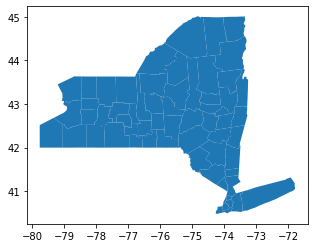

In [18]:
# NY state = statefp code 36
# select data and plot it
ny_counties = counties[counties.statefp == '36']
ny_counties.plot()

## Merging

The goal of this section is to create a single dataframe with the number of spills per county and the corresponding geometries for each county.

### Explore data

In the next cells:

1. Print the names of counties in `ny_counties`, without repetition.
2. Print the names of counties in `spills_per_county`, without repetition. (Do you notice anything?)
3. Use the [`numpy` function `setdiff1d`](https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html) to find the county names that are in `spills_per_county`, but not in `ny_counties`. HINT: read the example in the documentation.
4. Find the county names that are in `ny_counties`, but not in `spills_per_county`.
5. Check the number of spills in 'Tuscarora Indian Reservation'.


In [21]:
print('counties in spills_per_county, but not in ny_counties:', 
        np.setdiff1d(spills_per_county.county.unique(), ny_counties.name.unique()))
print('counties in ny_counties, but not in spills_per_county:',
        np.setdiff1d(ny_counties.name.unique(),spills_per_county.county.unique()))

array(['New Jersey - Region 2', 'St Lawrence',
       'Tuscarora Indian Reservation'], dtype=object)

Sth about New Jersey - Region 2 and Tuscarora Indian Reservation

In [23]:
# 5. 
spills_per_county[spills_per_county.county == 'Tuscarora Indian Reservation']


,county,n_spills
56,Tuscarora Indian Reservation,1


### Data updates

In this section we will update 'St Lawrence' to 'St. Lawrence' in `spills_per_county` data frame.

In the next cells:
1. Check the row in `spills_per_county` that has 'St Lawrence'
2. Run the code and read the explanation in the comments
3. Run the code and read the explanation in the comments
4. Use the `st_lawrence_index` and `at` to update St Lawrence name in `spills_per_county` dataframe
5. Check the update was successfull

In [24]:
# 1. 
spills_per_county.loc[spills_per_county.county=='St Lawrence']

,county,n_spills
50,St Lawrence,65


In [25]:
# 2. we can get the index of that single row like this, to access the actual row index...
spills_per_county[spills_per_county.county=='St Lawrence'].index

Int64Index([50], dtype='int64')

In [26]:
# 3. we need to select the first item in that tuple using [0]
st_lawrence_index = spills_per_county[spills_per_county.county=='St Lawrence'].index[0]
st_lawrence_index

50

In [27]:
# 4. 
spills_per_county.at[st_lawrence_index, 'county'] = 'St. Lawrence'

In [28]:
# 5.
spills_per_county.loc[spills_per_county.county == 'St. Lawrence','county']

50    St. Lawrence
Name: county, dtype: object

### Merge

In the following cells:
1. Use this cell to make any other updates needed for making an inner join of the `spills_per_county` and `ny_counties`. 
2. Over-write `ny_counties` as the  inner join of the `spills_per_county` and `ny_counties` dataframes.

From our previous exploration we know that Tuscarora Indian Reservation will not be in the join. Tuscarora Indian Reservation is located within Niagara county. 

3. Since the Tuscarora Indian Reservation does not appear in the `ny_counties` dataframe, add one spill to Niagara county. We will add a note about this in our final map. You may add all the cells to make this update **and** verify that the dataframe was updated.

In [29]:
# 1. 
ny_counties = ny_counties.rename(columns={'name':'county'})


In [30]:
# join dataframes
ny_counties = pd.merge(ny_counties, spills_per_county, how='inner', on='county')
ny_counties.head()

,statefp,countyfp,countyns,geoid,county,namelsad,lsad,classfp,mtfcc,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry,n_spills
0,36,101,00974148,36101,Steuben,Steuben County,06,H1,G4020,None,None,None,A,3601398422,35039875,+42.2667252,-077.3855253,"POLYGON ((-77.08327 42.00002, -77.09391 41.999...",71
1,36,091,00974143,36091,Saratoga,Saratoga County,06,H1,G4020,None,None,None,A,2097812305,87488004,+43.1061353,-073.8553872,"POLYGON ((-73.67891 42.91221, -73.67938 42.911...",158
2,36,003,00974100,36003,Allegany,Allegany County,06,H1,G4020,None,None,None,A,2666225086,12989848,+42.2478532,-078.0261531,"POLYGON ((-78.04342 42.51846, -78.04326 42.518...",30
3,36,075,00974136,36075,Oswego,Oswego County,06,H1,G4020,None,None,None,A,2464636023,933469962,+43.4614431,-076.2092618,"POLYGON ((-76.02509 43.70702, -76.02004 43.706...",68
4,36,111,00974153,36111,Ulster,Ulster County,06,H1,G4020,None,None,None,A,2911757764,94596810,+41.9472124,-074.2654582,"POLYGON ((-74.07480 42.09659, -74.06441 42.120...",158


In [31]:
# check Niagara row
ny_counties.loc[ny_counties.county=='Niagara','n_spills']

45    88
Name: n_spills, dtype: int64

In [32]:
# find index and add one
niagara_index = ny_counties[ny_counties.county=='Niagara'].index[0]
ny_counties.at[niagara_index, 'n_spills']+=1
ny_counties.loc[ny_counties.county=='Niagara']


,statefp,countyfp,countyns,geoid,county,namelsad,lsad,classfp,mtfcc,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry,n_spills
45,36,063,00974130,36063,Niagara,Niagara County,06,H1,G4020,None,None,None,A,1352887560,1598842379,+43.2726719,-078.8129431,"POLYGON ((-78.49165 43.08396, -78.49179 43.084...",89


## Map
Create a choropleth map of the number of petroleum spills per county in the state of New York in 2023. 
Your map should have (at least) the following updates:
- a legend indicating the number of spills
- an updated color map
- a title 
- no axis
- an annotation with the data source (New York State Department of Environmental Conservation), date of access HINT: check the graph we did for power plants, 
- an annotation indicating one spill occurred in Tuscarora Indian Reservation within Niagara county

Tuscarora Indian Reservation in Niagara county

Text(0.05, 0.16, 'The oil spill rerpoted in Tuscarora Indian Reservation, was added to Niagara county.')

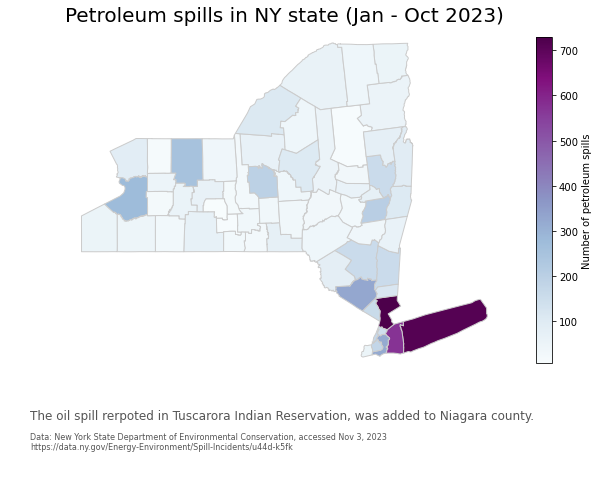

In [33]:
fig, ax = plt.subplots(figsize=(10,10))

ax.axis('off')
ax.set_title('Petroleum spills in NY state (Jan - Oct 2023)',  fontsize=20)

ny_counties.plot(ax=ax, 
                column='n_spills', 
                cmap='BuPu',
                legend=True,
                edgecolor="0.8",
                legend_kwds={"shrink":.6,
                             'label': "Number of petroleum spills"})

# annotate the data source
ax.annotate("Data: New York State Department of Environmental Conservation, accessed Nov 3, 2023 \nhttps://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk", 
            xy=(0.05, .1), # position
            xycoords='figure fraction', 
            fontsize=8, 
            color='#555555') 

# annotate Tuscarora
ax.annotate("The oil spill rerpoted in Tuscarora Indian Reservation, was added to Niagara county.", 
            xy=(0.05, .16), # position
            xycoords='figure fraction', 
            fontsize=12, 
            color='#555555') 


plt.show()